# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [2]:
#Import all the required libraries
import tensorflow as tf
import glob
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu


import string
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
# from tensorflow.keras.backend.tensorflow_backend import set_session
import pathlib

# import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from tensorflow.keras import Input, layers

from keras.applications.inception_v3 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import plot_model



Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [ ]:
#Import the dataset and read the image into a seperate variable

images='flickr8k/images'  # please modify flickrdataset path here

all_images = glob.glob(images + '/*.jpg',recursive=True)   # using glob to recursively scan all the jpg files and store
print("The total images present in the dataset: {}".format(len(all_images)))

## The location of the caption file
descriptions_dir = pathlib.Path('flickr8k/captions.txt')



In [ ]:
all_images[5]  # printing the path of the image file 

In [ ]:
#Visualise both the images & text present in the dataset
Image.open(all_images[5]) #using PIL library Image.open method 


#### We will now extract the image id and associated 5 captions from the caption.txt file

In [ ]:
#Import the dataset and read the text file into a seperate variable

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
text= load_doc(descriptions_dir)  # storing the captions txt data
print(text[:300])

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:] # removing the first line "image,caption which is a useless header"
    for line in text:
        com_idx=line.index(",") # getting index of comma separator
        im_id,im_cap=line[:com_idx],line[com_idx+1:] #dividing into image id and caption by comma index
        keys.append(im_id)   # adding to key, values list
        values.append(im_cap)
        key_paths.append(images+'/'+im_id)# creating the image path vector
        
    return keys,values,key_paths


In [ ]:
all_img_id,annotations,all_img_vector=get_img_ids_and_captions(text) # storing the image id,path and captions in lists

In [ ]:
# converting the lists into consolidated dataframe
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

In [ ]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda x: "<start>"+" "+x+" "+"<end>") # using lambda function to add the start and end tokens



#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

In [ ]:
all_img_path[:10]  # visualizing the image path vector

In [ ]:
annotations[0] # start and end token is added

In [ ]:
from pickle import dump

# save to file  (serializing by pickle file)
dump(annotations, open('captions.pkl', 'wb'))
dump(all_img_path, open('img_names.pkl', 'wb'))

In [ ]:
#Create the vocabulary & the counter for the captions

def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    print("Vocabulary Size : {}".format(len(set(out))))   # finding the number of unique vocabulary words 
    return out


vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

In [ ]:
#Visualise the top 30 occuring words in the captions


#write your code here
def df_word_count(vocabulary):  # we are creating a function that will create a dataframe of the words and count
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data) # converting  dict to dataframe
    dfword = dfword.sort_values(by='count', ascending=False)  # sorting in descending order of frequency
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)


In [ ]:
dfwordcount = df_word_count(vocabulary) # storing in a dataframe

In [ ]:
topn = 30
# the code below will display a bar plot of the most frequently and least frequently occuring words
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='b')
    plt.yticks(fontsize=20,color ='black')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='black')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 30 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 30 most frequently appearing words")

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [3]:
# uncomment the following if you want to load the serialized pkl files

# annotations = load(open('captions.pkl', 'rb'))
# all_img_path = load(open('img_names.pkl', 'rb'))

In [4]:
# create the tokenizer

#your code here
top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [5]:
for i in train_seqs[0]: # checking the first training caption sequence after tokenizing
    print(tokenizer.index_word[i],end=" ")
    

<start> a child in a pink dress is climbing up a set of stairs in an <unk> way <end> 

In [6]:
# Create word-to-index and index-to-word mappings.

#your code here
tokenizer.word_index['<pad>'] = 0   # creating an index-token pair for padding
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations) #adding the new pad token


In [7]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
def df_word_count(ct):  # we are creating a function that will create a dataframe of the words and count
   
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data) # converting  dict to dataframe
    dfword = dfword.sort_values(by='count', ascending=False)  # sorting in descending order of frequency
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)


In [8]:
dfwordcount = df_word_count(tokenizer.word_counts) # storing in a dataframe

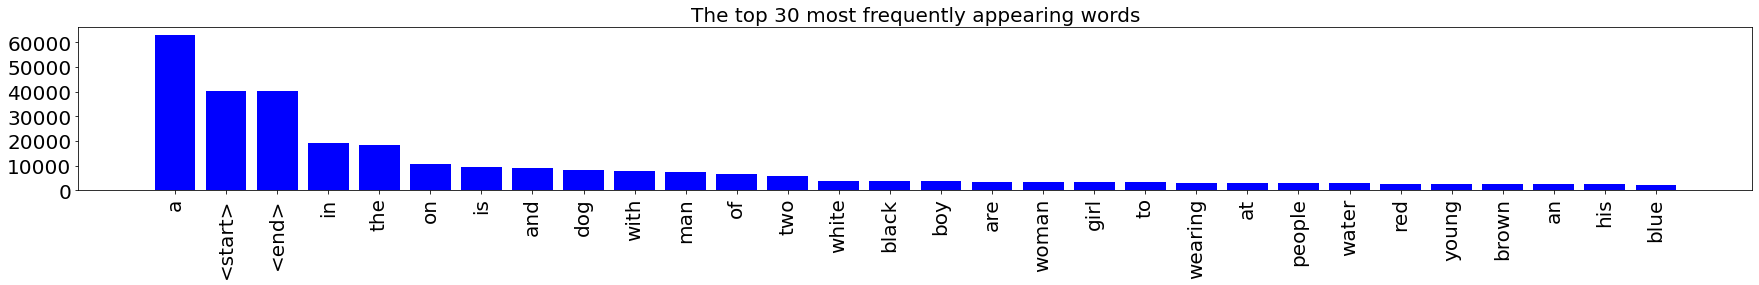

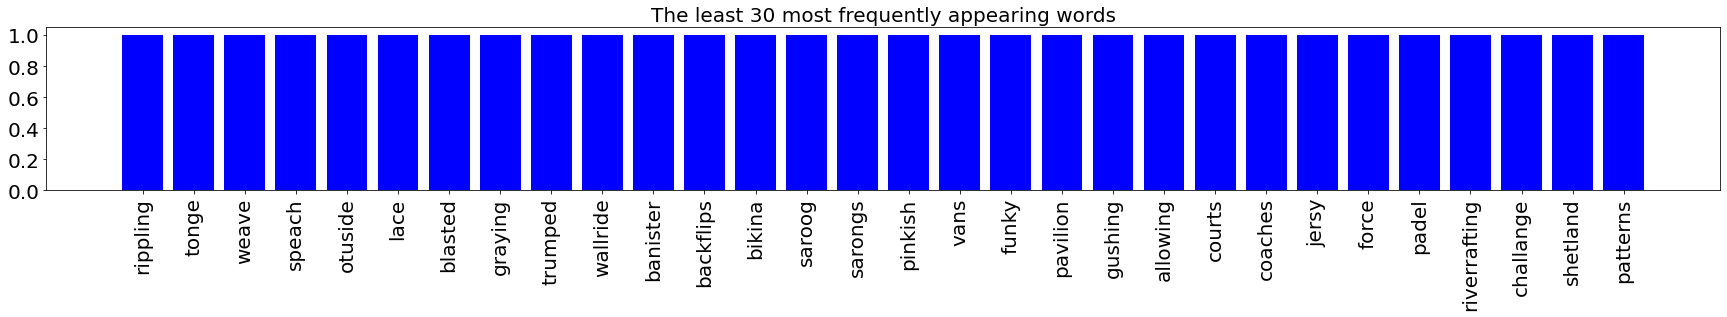

In [9]:
topn = 30
# the code below will display a bar plot of the most frequently and least frequently occuring words
def plthist(dfsub, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='b')
    plt.yticks(fontsize=20,color ='black')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='black')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 30 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 30 most frequently appearing words")

In [10]:
# We are creating a function that will find the maximum length in all the training sequences.
def min_max(cap_data):
    array=[len(e) for e in cap_data] # finding length of each list of captions
    return min(array),max(array)
min_l,max_l=min_max(train_seqs)

In [11]:
# finding the max length of training captions
max_l

39

In [12]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_l)  # using post padding because the start token is used in the decoder

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [13]:
all_img_path[:10]  # viewing the image path vector

['flickr8k/images/1000268201_693b08cb0e.jpg',
 'flickr8k/images/1000268201_693b08cb0e.jpg',
 'flickr8k/images/1000268201_693b08cb0e.jpg',
 'flickr8k/images/1000268201_693b08cb0e.jpg',
 'flickr8k/images/1000268201_693b08cb0e.jpg',
 'flickr8k/images/1001773457_577c3a7d70.jpg',
 'flickr8k/images/1001773457_577c3a7d70.jpg',
 'flickr8k/images/1001773457_577c3a7d70.jpg',
 'flickr8k/images/1001773457_577c3a7d70.jpg',
 'flickr8k/images/1001773457_577c3a7d70.jpg']

In [ ]:
#write your code here to create the dataset consisting of image paths


In [14]:
#write your code here for creating the function. This function should return images & their path
 # this functions loads all the images from the path vector and processes them to be compatible with inception v3
def load_image(image_path):
    #write your pre-processing steps here
    my_img = tf.io.read_file(image_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))  #reshaping for inception v3 input 
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    return my_img,image_path
    
     

In [18]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
encoded_train_set = sorted(set(all_img_path))  # removing duplicate filepaths



image_data_set = tf.data.Dataset.from_tensor_slices(encoded_train_set) 


image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64) # It loads the images from the paths in batches
image_data_set


<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [19]:
# image_data_set is a tuple; (images,captions)
print(image_data_set.as_numpy_iterator().next()[0].shape ) # a batch of 32 images preprocessed for inception model
print(f'the image paths are {image_data_set.as_numpy_iterator().next()[1][:5]} and shape is {image_data_set.as_numpy_iterator().next()[1].shape}')

(64, 299, 299, 3)
the image paths are [b'flickr8k/images/1000268201_693b08cb0e.jpg'
 b'flickr8k/images/1001773457_577c3a7d70.jpg'
 b'flickr8k/images/1002674143_1b742ab4b8.jpg'
 b'flickr8k/images/1003163366_44323f5815.jpg'
 b'flickr8k/images/1007129816_e794419615.jpg'] and shape is (64,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


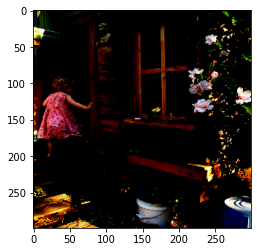

In [20]:
plt.imshow(image_data_set.as_numpy_iterator().next()[0][0]) # displaying one preprocessed image input

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



#### We will now save all the training images in .npy format after passing it through the inception v3 to pass to the encoder. The encoder does not have the CNN extraction model. It only compresses the 2048 dimensionaloutput into a output of the embedding size dimension for the decoder

In [21]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output # getting the last layer of the pretained model as output layer

extraction_model = tf.keras.Model(new_input, hidden_layer)

In [22]:
extraction_model.summary() # checking the model structure

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
extraction_model(image_data_set.as_numpy_iterator().next()[0]).shape  # the output of inception model :(batch,8,8,2048)

TensorShape([64, 8, 8, 2048])

#### We will be passing the images from the created tf.dataset through our inception model; reshaping the (batch,8x8x2048) into (batch,64,2048) and storing them in the same path as images in .npy format to be used later during training 

In [24]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)


for img, path in tqdm(image_data_set): # tqdm is for progress bar
  batch_features = extraction_model(img) # getting the output from inception model
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3])) # compressing the output to 32x64x2048
  for bf, p in zip(batch_features, path): # pairing  the extracted image features and their paths
    path_of_feature = p.numpy().decode("utf-8") # converting byte type string into unicode string
    np.save(path_of_feature, bf.numpy())# saving features as .npy file


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [01:26<00:00,  1.47it/s]


In [25]:
bf.shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [27]:
print(np.array(all_img_path)[:6]) # viewing the dataset
for i in cap_vector[:6]:
    for word in i:
        print(tokenizer.index_word[word],end=' ')  # converting the tokenized captions back to words to visualize data
    print('\r')
    print('\r')
    

['flickr8k/images/1000268201_693b08cb0e.jpg'
 'flickr8k/images/1000268201_693b08cb0e.jpg'
 'flickr8k/images/1000268201_693b08cb0e.jpg'
 'flickr8k/images/1000268201_693b08cb0e.jpg'
 'flickr8k/images/1000268201_693b08cb0e.jpg'
 'flickr8k/images/1001773457_577c3a7d70.jpg']
<start> a child in a pink dress is climbing up a set of stairs in an <unk> way <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

<start> a girl going into a wooden building <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

<start> a little girl climbing into a wooden playhouse <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

<start> a little girl climbing the stairs to her play

We see how the training data comprises the path to the images and the training captions has the tokenized(word-to-index) captions

In [28]:
# creating train-test split

path_train, path_test, cap_train, cap_test = train_test_split(all_img_path,cap_vector,test_size=0.2,random_state=42)

In [29]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


#### This helper function reads the trainining image path names and decodes the byte string created and adds .npy.  This helps to extract the npy feature files for the encoder.

In [30]:
BATCH_SIZE = 64         # definining the batch size and buffer size for prefetching
BUFFER_SIZE = 1000

In [31]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def load_npy(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')  # decoding the byte string coming from tf tensorslice format and adding .npy
  return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

<font color='green'> This generator function takes the training/testing image-captions and creates tf.dataset. It maps to the function and loads the saved .npy image files, shuffles them and creates prefetch data. It helps in reducing training time.

dataset.shuffle :  Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
    
from tensor slices: Creates a Dataset whose elements are slices of the given tensors.
    
tf.nump_function: Creates a Dataset whose elements are slices of the given tensors.
 </font>   

In [32]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier




def gen_dataset(img_name_train,caption_train):
    dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train)) # converting into tf.dataset tensor

  # Use map to load the numpy files in parallel
  # This functions maps the inputs to the load npy function and specifies the datatypes. This also adds paralleling calling to reduce idling
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffling dataset with buffer size defined above and creating prefetch to reduce idling and improve training time
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    
    
    
    return dataset



In [33]:
train_dataset=gen_dataset(path_train,cap_train)   # creating train and test datasets (no separate X-train,y-train)
test_dataset=gen_dataset(path_test,cap_test)

In [34]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [35]:
embedding_dim = 256    # input caption embedding vector size
units = 512  # number of GRU units
vocab_size =5001 #top 5,000 words +1
train_num_steps =len(path_train) // BATCH_SIZE   # number of epochs
print(f'train steps are {train_num_steps}')

test_num_steps =len(path_test) // BATCH_SIZE
print(f'test steps are {test_num_steps}')

EPOCHS = 20
# Shape from last layer of inceptionV3 :(8,8,2048)
# So, say there are 64 pixel locations now and each pixel is 2048 dimensional
features_shape = 2048  # this is the depth of the feature map
attention_features_shape = 64  # number of pixels

train steps are 505
test steps are 126


### Encoder

<font color ='green'> We create an encoder class that has a fully connected layer as attribute. This encoder simply 
 passes the batch image tensor through a fully connected layer of units = embedding layer size and uses relu activation. The encoder compresses the inception v3 2048 dimensions into 256 dimensions </font>   

In [36]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()  # inheriting all parent class attributes
        self.fc =layers.Dense(embedding_dim)  # embedding layer for the input token of 256 size
        self.dropout=layers.Dropout(0.2) # dropout layer
        
        
    def call(self, features):
        features =  self.fc(features)
#         features=self.bn(features,training=training)
        features=tf.nn.relu(features)  # activation layer
        features=self.dropout(features)
        return features
    
    def model(self):   # used for plotting
        x=Input(shape=(64,2048))
        return Model(inputs=[x],outputs=self.call(x))

In [37]:
encoder=Encoder(embedding_dim)  # creating an object of encoder class


In [38]:
encoder.model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 2048)]        0         
_________________________________________________________________
dense (Dense)                (None, 64, 256)           524544    
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 64, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 256)           0         
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


<header>
        <h4>Encoder plot</h4>
</header>    

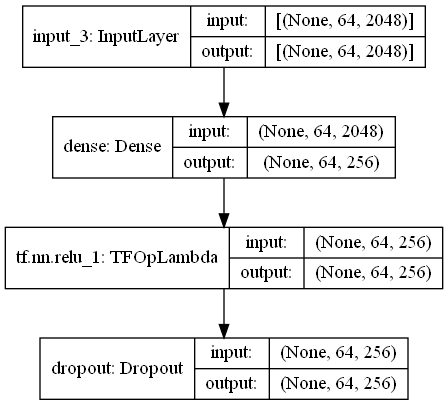

In [39]:
plot_model(encoder.model(),to_file='encoder.png',show_shapes=True)

### Attention model

<p>Attention mechanisms solve the problem of the older encoder-decoder models where the spatial information of the images would be lost. The last hidden layer of the feature map would be fed to the decoder. The standard seq2seq model is generally unable to accurately process long input sequences, since only the last hidden state of the encoder RNN is used as the context vector for the decoder. On the other hand, the Attention Mechanism directly addresses this issue as it retains and utilises all the hidden states of the input sequence during the decoding process. It does this by creating a unique mapping between each time step of the decoder output to all the encoder hidden states. This means that for each output that the decoder makes, it has access to the entire input sequence and can selectively pick out specific elements from that sequence to produce the output.

Therefore, the mechanism allows the model to focus and place more “Attention” on the relevant parts of the input sequence as needed.</p>


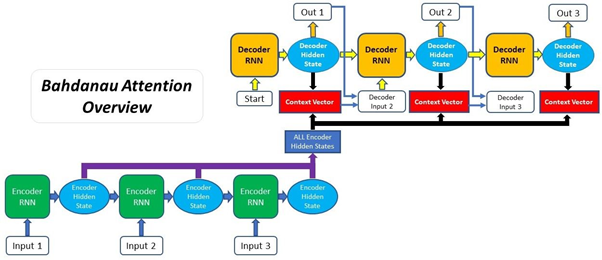

##### https://blog.floydhub.com

<p> <font color='green'>First we calculate all the encoder hidden state as a feature vector batchwise and this is sent to the attention unit of the decoder at each time step. At each time step of the decoder, we have to calculate the alignment score of each encoder output with respect to the decoder input and hidden state at that time step. The alignment score is the essence of the Attention mechanism, as it quantifies the amount of “Attention” the decoder will place on each of the encoder outputs when producing the next output.
The decoder hidden state and encoder outputs will be passed through their individual Linear layer and have their own individual trainable weights.Thereafter, they will be added together before being passed through a tanh activation function. The decoder hidden state is added to each encoder output in this case. Lastly, the resultant vector from the previous few steps will undergo matrix multiplication with a trainable vector, obtaining a final alignment score vector which holds a score for each encoder output. After generating the alignment scores vector in the previous step, we can then apply a softmax on this vector to obtain the attention weights. The softmax function will cause the values in the vector to sum up to 1 and each individual value will lie between 0 and 1, therefore representing the weightage each input holds at that time step.</p>

<p><b><h>Context Vector:</h></b> The attention scores are element wise multiplied with the encoder outputs. If the score is 1 the encoder output is given amplified and if the score is 0 then the influence is nulled.</p>
<p><b>Producing the output:</b> The context vector is formed by concatenating the attention weights with the decoder output of the previous time step (or the actual token during training -teacher forcing) . The lstm outputs  a new hidden state that is passed through fully connected layers to produce  probability scores of the next predicted word.</p></font>


<font color='blue'>  Defining the attention layer:  We will create a class that inherits from keras.Model superclass and implement  a call method. It initializes attributes of the trainable weights for the hidden state and the encoder outputs and also the alignment score weight. The context vector is defined here and it is returned to the calling function along with the attention weights. An object of  attention class is created by the decoder below </font>
 

In [40]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)# weights to multiply with feature vector 
        self.W2 = layers.Dense(units)#weights to multiply with hidden state of t-1
        self.V = layers.Dense(1)#to convert score vector to scalar
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim) ==>(64,64,256) :output from encoder
        # hidden shape: (batch_size, hidden_size) ==>(64,512)
        hidden_with_time_axis =   tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size) to match dimension
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
   # self.W1(features) : (64,64,512)
   # self.W2(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,64,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,64,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
        
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
   # Context Vector(64,256) = AttentionWeights(64,64,1) * features(64,64,256)
   # context_vector shape after sum == (64, 256)  # we will need to expand dims by 1 to be able to concatenate with input token vector

        return context_vector, attention_weights
    

### Decoder

<font color='blue'> We will now define the decoder class that also inherits from keras.MOdel superclass. It creates instances of attention layer (from class attention), gru layer and fully connected layers. We also implement dropouts. We pass the input tokens at each time step through an embedding layer and concatenate it with the context vector and pass it to the GRU. The GRU returns an output and hidden state; the output is passed through  dense layers to produce probabilities </font>

In [41]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim,mask_zero=False)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer
        self.dropout = Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights =self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x))  # embed your input to shape: (batch_size, 1, embedding_dim)
        mask =  self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# x shape after concatenation == (64, 1,  512)
        output,state = self.gru(embed,mask=mask)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    def model(self):    # this is used to create the model plot
        x1=Input(shape=(1))
        x2=Input(shape=(64,256))
        x3=Input(shape=(512))
        
        return Model(inputs=[x1,x2,x3],outputs=self.call(x1,x2,x3))

In [42]:
decoder=Decoder(embedding_dim, units, vocab_size)   # creating an object of Decoder class

In [43]:
sample_img_batch.shape  # the input tensor of a sample batch

TensorShape([64, 64, 2048])

In [44]:
# Here we are testing our model by using a batch of data. We are passing a hidden state, a <start> token as decoder input and a feature vector

features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
print(f'features shape is {features.shape} hidden shape is {hidden.shape} and dec_input shape is {dec_input.shape}')

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

features shape is (64, 64, 256) hidden shape is (64, 512) and dec_input shape is (64, 1)
Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


<header>
      <h4>The Decoder attention layer plot </h4>
</header>

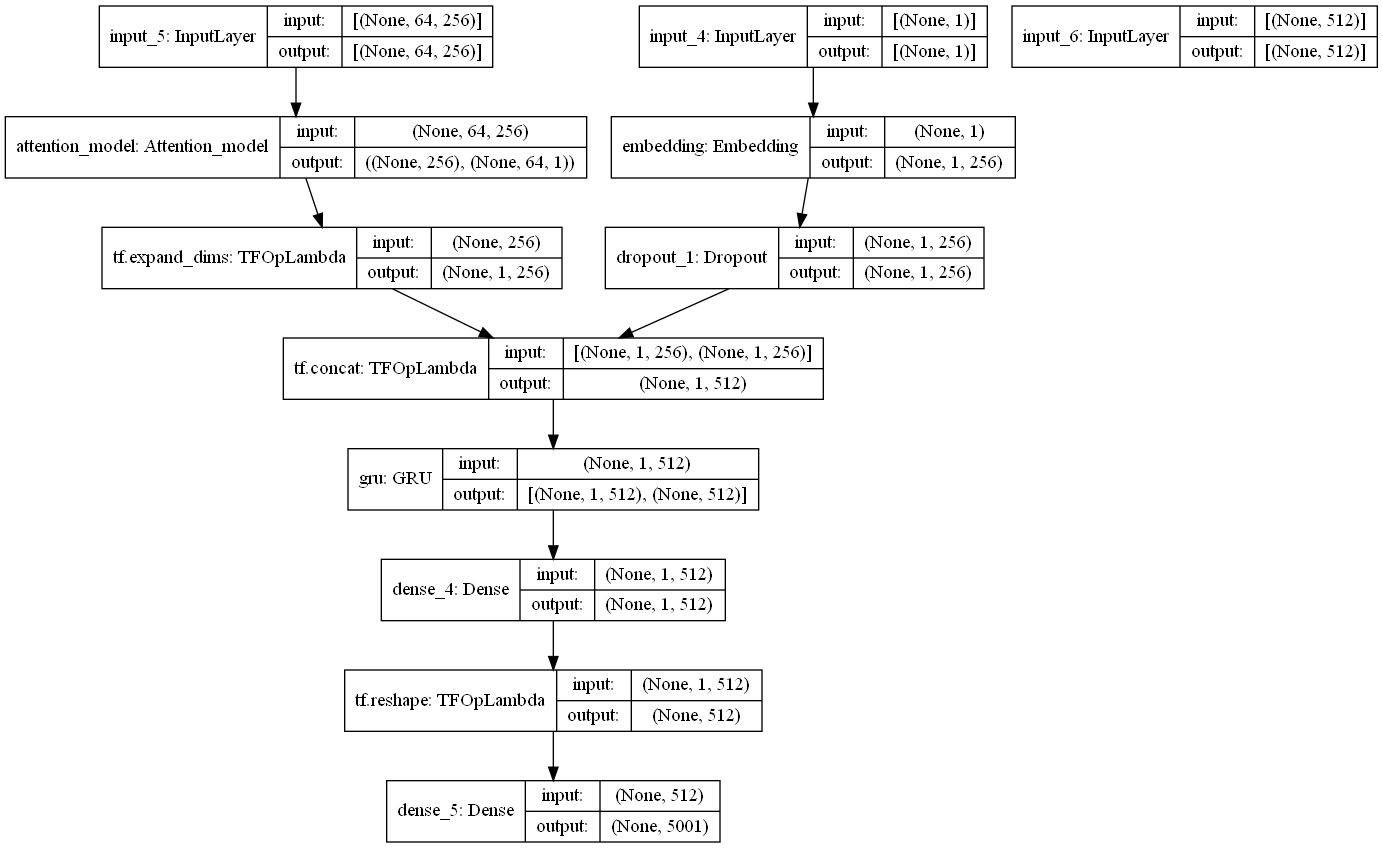

In [45]:
plot_model(decoder.model(),to_file='decoder.png',show_shapes=True)

<p> We see how the concatenation of the context vector and the embedding layer happens. The output is of 5001 dimensions</p>


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [46]:
optimizer = tf.keras.optimizers.Adam()  # creating adam optimizer instance
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')    # as model outputs softmax probabilities      

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #for padding
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype) # type casting into loss type
  loss_ *= mask

  return tf.reduce_mean(loss_) # summing up the loss

In [47]:
checkpoint_path = "submit_checkpoint"        # creating checkpoint folder
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [48]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [49]:
# displaying start epoch
start_epoch

2

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [50]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset

loss_plot = []

<font color ='green'> We will now define the training and testing functions. These methods are called during training/testing. It reintializes the hidden state of decoder after each batch and creates the start token for the batch. It uses tf Auto-differentiation 'gradient tape' to calculate gradients with respect to all the trainable weights of the encoder-decoder. It keeps the loop running till the max length of the training captions and stores the loss of individual word and average loss per batch. It executes gradient descent and optimizes the weights, finally returns the loss</font>

In [51]:

@tf.function #  @tf.function converts a Python function to its graph representation.
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:  # we will calculate the gradients and backpropagate the loss
        features = encoder(img_tensor) 

        for i in range(1, target.shape[1]): # interating through max length of captions
          # passing the features through the decoder
          #dec_input = tf.expand_dims(target[:, i], 1)
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions) #passing actual token at ith position for all batches and predicted token

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1) # updating decoder input to actual token at ith position for t+1 input


    avg_loss = (loss / int(target.shape[1])) #calculating average loss for 1 batch of data

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables # storing all weights 

    gradients = tape.gradient(loss, trainable_variables) # gradient of loss with respect to all weights

    optimizer.apply_gradients(zip(gradients, trainable_variables)) #applying optimization and weight updation

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [52]:
test_loss_plot = []

The test functions is same as the training function except here the teacher forcing is not used, and the decoder outputs are passed to the next time step input and the gradient descent is not used

In [53]:
# we will not use teacher forcing during testing
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] *target.shape[0] , 1)

    features = encoder(img_tensor) 

    for i in range(1, target.shape[1]):
    # passing the features through the decoder

        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        loss += loss_function(target[:, i], predictions)

        predicted_id = tf.argmax(predictions[0]) # TO be used as input for t+1 input to decoder
        dec_input = tf.expand_dims([predicted_id]*target.shape[0], 1) # reshaping input token


    avg_loss = (loss / int(target.shape[1])) # calculating average test loss for 1 batch

    
        
    return loss, avg_loss

In [54]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target) # no teacher forcing is used
        total_loss += t_loss 
    avg_test_loss=total_loss/test_num_steps  #total loss divided by total number of batches
    
    
    return avg_test_loss

In [55]:
# This is the main training loop that takes in the batches of training data, calls the training function and saves the losses

EPOCHS = 3

best_test_loss=100  # reference init loss
for epoch in tqdm(range(start_epoch, EPOCHS)):   # start epoch takes the latest checkpoint and resumes training 
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)  #calling train function
        total_loss += t_loss # total epoch loss
        avg_train_loss=total_loss / train_num_steps  # avg epoch loss
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)  # calling test function 
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:  #saving only if loss has improved
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For epoch: 3, the train loss is 1.280, & test loss is 1.881
Time taken for 1 epoch 151.51440715789795 sec

Test loss has been reduced from 100.000 to 1.881


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:32<00:00, 152.52s/it]


In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score


### Greedy Search

In [56]:
# Loading the latest checkpoint
ckpt_manager.checkpoints

['submit_checkpoint\\ckpt-2', 'submit_checkpoint\\ckpt-1']

In [57]:
ckpt.restore('./submit_checkpoint/ckpt-1')  # restoring all the weights from latest ckpoint. Modify accordingly

<font color ='blue'> The evaluate method uses greedy search algorithm where the final output at any time step is picked by the maximum probability. The next caption is decided by the previous predicted caption. The weights of the encoder-decoder are already loaded and the decoder keeps producing the output words till the end token is produced or the max length is reached. The attention weights are used to plot the attention maps for each word generated</font>

In [58]:
def evaluate(image):
    attention_plot = np.zeros((max_l, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val =extraction_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_l):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id]) # Store the result of word predicted
        #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':# if you reach <end> token then return the result
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)# Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


<font color='green'> Greedy Search algorithm selects one best candidate as an input sequence for each time step. Choosing just one best candidate might be suitable for the current time step, but when we construct the full sentence, it may be a sub-optimal choice.

The beam search algorithm selects multiple alternatives for an input sequence at each timestep based on conditional probability. The number of multiple alternatives depends on a parameter called Beam Width B. At each time step, the beam search selects B number of best alternatives with the highest probability as the most likely possible choices for the time step
    
<b>Step 1:</b> Find the top 3 words with the highest probability given the input sentence. The number of most likely words are based on the beam width  
<b>Step 2:</b>  Find the three best pairs for the first and second words based on conditional probability   
<b>Step 3: </b> Find the three best pairs for the first, second and third word based on the input sentence and the chosen first and the second word   
 
A higher beam width will give a better translation but would use a lot of memory and computational power.    

### Beam Search(optional)

In [59]:
def beam_evaluate(image, beam_index = 3):   #taking beam width =3 ; can be modified

    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_l, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = extraction_model(temp_input)  # extracting features from image using inception
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val) # returning compressed feature vector from encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    while len(result[0][0]) < max_l:
        i=0
        temp = []
        for s in result:
            
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
            
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]   # taking the indices with 'beam width' most high probabilities
            
          
            for w in word_preds:       # here we implement the beam search ; the algo is same as breadth first search
              
                
                next_cap, prob = s[0][:], s[1]
               
                next_cap.append(w)
             
            
                prob += np.log(predictions[0][w])
              
                    
                temp.append([next_cap, prob])
         
        result = temp
        
        result = sorted(result, reverse=False, key=lambda l: l[1])  # sorting as per probability
       
        result = result[-beam_index:]  # selecting the words with probability as per beam width
       
        
        
        predicted_id = result[-1]
        
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]

    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break
    
    
    
    final_caption = ' '.join(final_caption[1:])
    attention_plot = attention_plot[:len(final_caption.split()), :]
    
    return final_caption,attention_plot
                  
    



In [60]:

# I had to modify the plotting code because the attention maps were causing error if the caption length was 2 words

def plot_attmap(caption, weights, image):
    
    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    print(f'len cap is {len_cap}')
    if len_cap%2==0 and (len_cap//2)>1:   # checking if the length of caption is even and more than a single word to create subplots
        for cap in range(len_cap):
            
            
            weights_img = np.reshape(weights[cap], (8,8))
            weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

            ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
            ax.set_title(caption[cap], fontsize=15)

            img=ax.imshow(temp_img)

            ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
            ax.axis('off')
    elif len_cap%2!=0 and (len_cap//2)>1:  # if the length of caption is odd then restrict the plotmaps to prevent error
        for cap in range(len_cap-1):
            weights_img = np.reshape(weights[cap], (8,8))
            weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

            ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
            ax.set_title(caption[cap], fontsize=15)

            img=ax.imshow(temp_img)

            ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
            ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()


<font color ='green' >bleu-score Reference translation is Human translation. Candidate Translation is Machine translation

To measure the machine translation effectiveness, we will evaluate the closeness of the machine translation to human reference translation using a metric known as BLEU-Bilingual Evaluation Understudy.

BLEU compares the n-gram of the candidate translation with n-gram of the reference translation to count the number of matches. The more the number of matches between candidate and reference translation, the better is the machine translation.</font>

In [61]:
from nltk.translate.bleu_score import sentence_bleu # importing bleu score from nltk library

In [62]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [63]:
# using google text to speech library for text to audio translation

# import gTTS
# please pip install gTTS if getting error
from gtts import gTTS

BELU score: 37.79644730092272
Real Caption: two dogs playing in the snow
Prediction Caption: a dog is running in the snow
len cap is 8


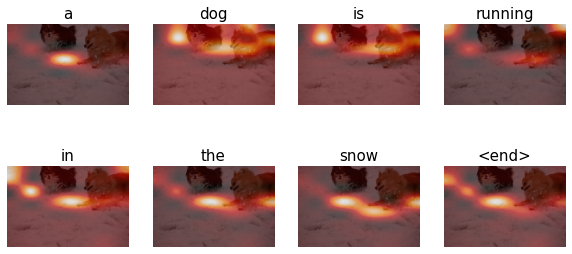

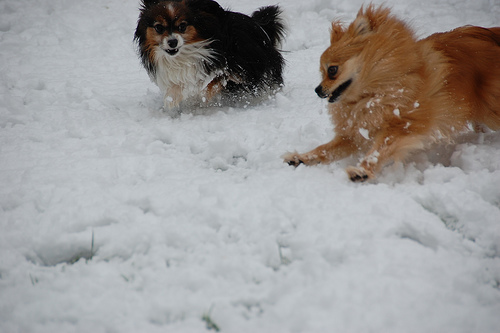

In [65]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]


real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)  # removing start-end tokens from real caption    


pred_caption=' '.join(result).rsplit(' ', 1)[0]  # removing end token from predicted caption

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0)) # setting n-gram weights
print(f"BELU score: {score*100}") # total bleu score as percentage

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)  # attention map

# we will use gTTS to convert text to speech to read the captions aloud

path = "captions.mp3"
output = gTTS(text = str(result[:-1]), lang = 'en',slow = False)
output.save(path)
import os
os.system('captions.mp3')
    


Image.open(test_image)

In [ ]:
captions,plot=beam_evaluate(test_image,3)  # now using beam search on the same image with width 3
print(captions)

#### Now we will test on completely new image from google

In [71]:
image_url = 'https://images.unsplash.com/photo-1502086223501-7ea6ecd79368?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8MTB8fHxlbnwwfHx8fA%3D%3D&w=1000&q=80'

Image_path = tf.keras.utils.get_file('image_11',
                                     origin=image_url)

204800/197166 [===============================] - 0s 1us/step


a little girl in a air
len cap is 6


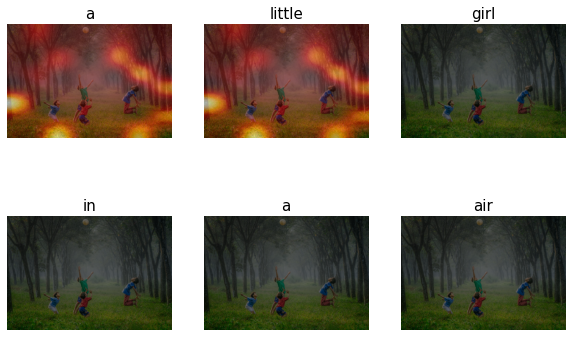

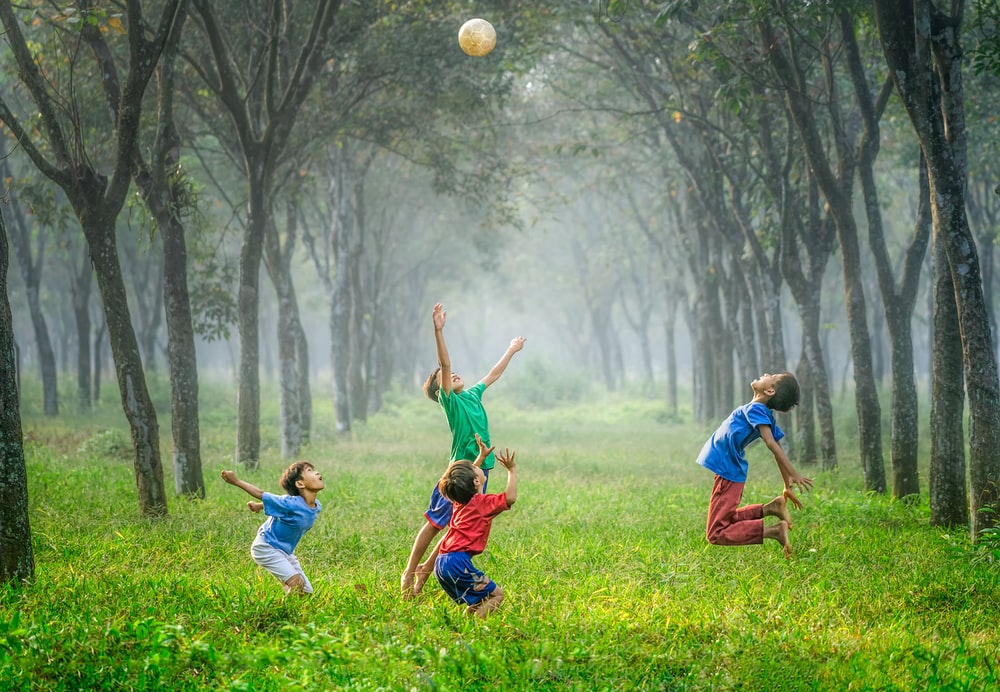

In [72]:
test_image = Image_path


result,attention_plot= beam_evaluate(test_image,2)


print(result)
plot_attmap(result.split(), attention_plot, test_image)


Image.open(test_image)